In [101]:
import sqlite3 as lite
import math
import time
import sys
import json
import pandas as pd
import os
import ftplib
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
plt.style.use('ggplot')


start_time = time.time()



In [102]:
sample_data = False

In [103]:
time_format = "%Y-%m-%dT%H:%M"


k = 0.12
scale_m = 1.91
scale_a = 0.234
delay = np.timedelta64(60, 'm') # 60 minutes

def f(x):
    return math.exp(k*x)
def g(x):
    return (scale_m * x) + scale_a
def f_inv(x):
    return math.log(x) / k
def g_inv(x):
    return (x - scale_a) / scale_m

In [104]:
# Get current time rounded down to nearest 15 minutes
current_time = time.time()
current_time = current_time - (current_time % (15*60))
current_time = pd.to_datetime(current_time, unit='s')

if sample_data:
    current_time = pd.to_datetime('2016-11-21 18:30:00') 

print current_time

2016-12-10 19:00:00


# Load data from sql database into pandas df

In [105]:
if sample_data:
    database = 'sample_data.db'
else:
    database = '../data.db'
river = 'dart'
limit = 200
con = lite.connect(database)
cur = con.cursor()
query = """
        SELECT timestamp, rain, level, forecast 
            from {river}
        ORDER BY timestamp DESC
        LIMIT {limit}
    """
cur.execute(query.format(river=river, limit=limit))
result = cur.fetchall()
df = pd.DataFrame(result, columns=['timestamp', 'cum_rain', 'level', 'forecast'])
df.head()

,timestamp,cum_rain,level,forecast
0,2016-12-11T21:00,NaN,NaN,0.0
1,2016-12-11T18:00,NaN,NaN,0.0
2,2016-12-11T15:00,NaN,NaN,0.0
3,2016-12-11T12:00,NaN,NaN,0.0
4,2016-12-11T09:00,NaN,NaN,0.0


# Set index to timestamp column as object

In [106]:
df.timestamp = pd.to_datetime(df.timestamp)
df = df.set_index('timestamp')
df = df.sort_index()
df.head()

,cum_rain,level,forecast
timestamp,,,
2016-12-08 19:15:00,NaN,0.457,NaN
2016-12-08 19:30:00,NaN,0.455,NaN
2016-12-08 19:45:00,NaN,0.452,NaN
2016-12-08 20:00:00,NaN,0.450,NaN
2016-12-08 20:15:00,NaN,0.447,NaN


# Pre-model checks

In [107]:

# Check that there is a level update in df
if len(df[df.level.notnull()]) == 0:
    print 'No level updates'
    
# Check that there is a row for now or past now
if len(df[df.index >= current_time]) == 0:
    print 'Not enough data'


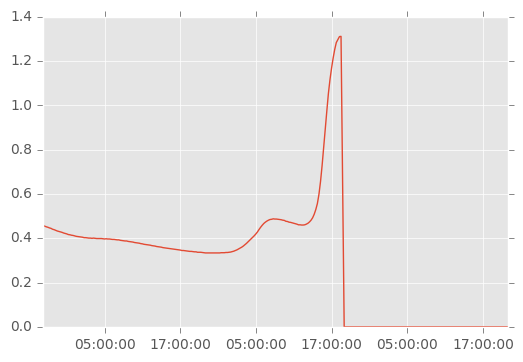

In [108]:
plt.plot(df.level.fillna(0))

# Calculate important timestamps

In [109]:
latest_level_time = max(df.index[df.level.notnull()])

print latest_level_time
latest_level = df.loc[latest_level_time].level
print latest_level

2016-12-10 18:30:00
1.312


In [110]:
latest_rain_time = max(df.index[df.cum_rain.notnull()])

print latest_rain_time

2016-12-10 19:00:00


# Fill in missing timestamps

In [111]:
min_time = min(df.index)
max_time = max(df.index)
rng = pd.date_range(min_time, max_time, freq='15Min')
df = df.reindex(rng)


# Cumulative rain -> actual rain

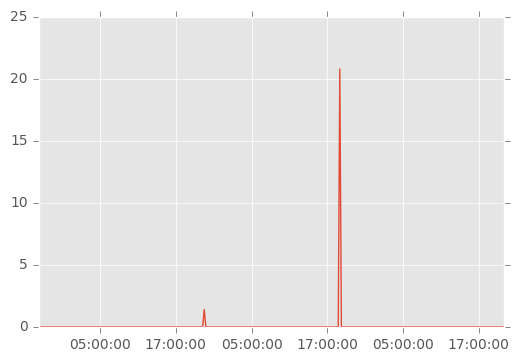

In [112]:
plt.plot(df.cum_rain.fillna(0))

In [113]:
df['rain'] = df['cum_rain'].diff(periods=2)
df.loc[df['rain'] < 0, 'rain'] = 0 
# interpolate and div 2 to get actual rain every 15 min
df['rain'] = df['rain'].interpolate()
df['rain'] = df['rain'] / 2

# multiply by 4 to get rain rate per hour
df['rain'] = df['rain'] * 2


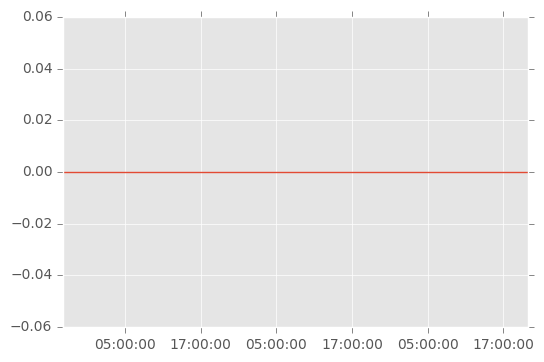

In [114]:
plt.plot(df['rain'].fillna(0))

# Interpolate forecast

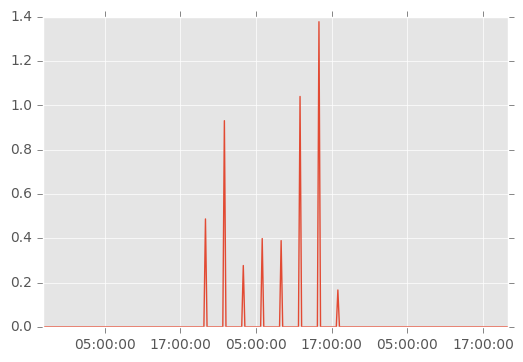

In [115]:
# Input forecast data is in mm/hour
plt.plot(df.forecast.fillna(0))

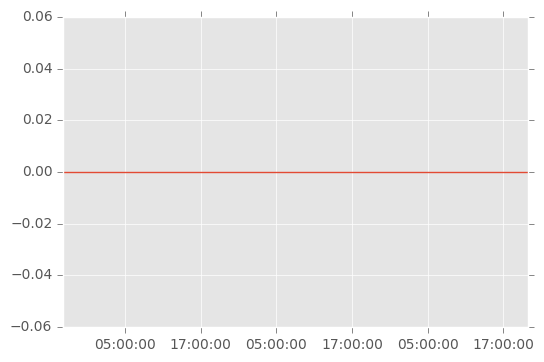

In [116]:
# Remove forecast before latest_rain_time
df.loc[min_time:latest_rain_time, 'forecast'] = None

# Set forecast to rain at latest_rain_time
df.loc[latest_rain_time].forecast = df.loc[latest_rain_time].rain

df['forecast'] = df['forecast'].interpolate()

plt.plot(df.forecast.fillna(0))

# Run model

In [117]:
df['model_rain'] = df['forecast'].fillna(0) + df['rain'].fillna(0)
df['storage'] = np.nan
df['predict'] = np.nan

# Calculate initial storage
init_storage = f_inv(g_inv(latest_level))
df.loc[latest_level_time, 'storage'] = init_storage

# Run iteration for indexes > latest_level_update
storage = init_storage
df_model = df[(df.index > pd.Timestamp(latest_level_time))]
for i,r in df_model.iterrows():
    rain = df.loc[i - delay, 'model_rain']
    predict = g(f(storage))
    storage = storage + rain - f(storage)
    df.loc[i, 'storage'] = storage
    df.loc[i, 'predict'] = predict

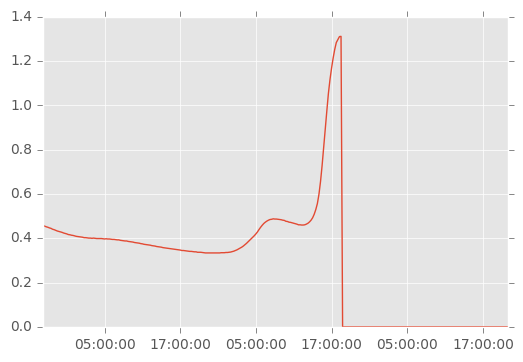

In [118]:
plt.plot(df.level.fillna(0))

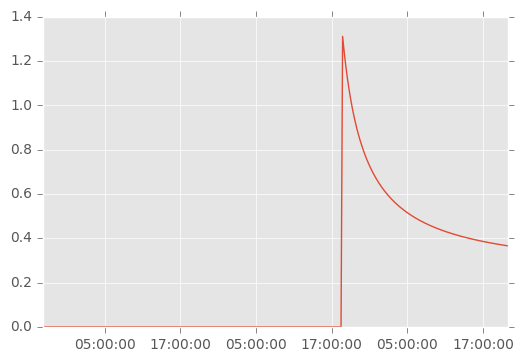

In [119]:
plt.plot(df.predict.fillna(0))

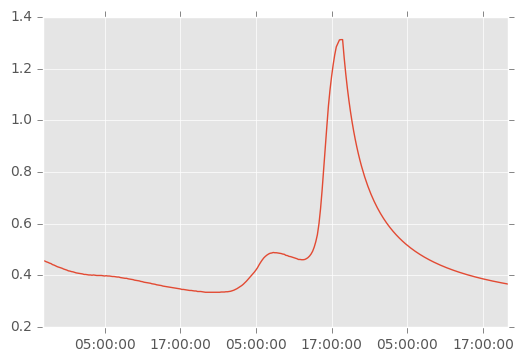

In [120]:
plt.plot(df.level.fillna(0) + df.predict.fillna(0))

# Create export dictionary

* Round model_rain, level and predict
* Get current time rounded down to nearest 15 minutes
* create output dict with the following properties
    * values
    * current_time
    * current_level
    * text
    * next_up if in next hour

In [121]:
# Round export columns
df = df.round({'level': 3, 'predict': 3, 'model_rain' : 1})

In [122]:

try:
    current_row = df.loc[pd.to_datetime(current_time, unit='s')]
    current_level = current_row['level']
    if np.isnan(current_level):
        current_level = current_row['predict']
except KeyError:
    print "Can't find row in df that matches current time: "+ time.strftime(time_format, time.gmtime(current_time))
    current_level = None
    
print current_level

1.241


In [123]:

df.timestamp = df.index
df = df.where((pd.notnull(df)), None)
timestamp_vals = [timestmp.value / 1000 for timestmp in df.index.tolist()]
rain_vals = df.model_rain.tolist()
level_vals = df.level.tolist()
predict_vals = df.predict.tolist()
values = []
for n in range(0, len(timestamp_vals)):
    values.append({'timestamp' : timestamp_vals[n], 'rain' : rain_vals[n], 'level' : level_vals[n], 'predict' : predict_vals[n]})


In [124]:
if current_level > 1.5:
    text = "THE DART IS MASSIVE"
elif current_level > 0.7:
    text = 'YES'
else:
    next_up = df[(df.index > current_time) & (df.index < current_time + delay) & (df.predict > 0.2)].index.min()
    if pd.isnull(next_up):
        text = 'NO'
    else:
        text = "THE DART WILL BE UP SHORTLY"    
print text

YES


In [125]:
output = {}       
output['current_time'] = current_time.value / 1000
output['current_level'] = current_level 
output['text'] = text
output['values'] = values


# Write export to json

In [84]:
filename = 'dart.json'
with open(filename, 'w') as f:
    json.dump(output, f)

ftp_url = 'ftp.isthedartrunning.co.uk'
ftp_pass = 'EScc290@'
ftp_user = 'isthedartrunningcouk'
ftp_dir = 'testing'

ftp = ftplib.FTP(ftp_url)
ftp.login(ftp_user, ftp_pass)
if ftp_dir is not None:
    ftp.cwd(ftp_dir)

ext = os.path.splitext(filename)[1]
if ext in (".txt", ".htm", ".html"):
    ftp.storlines("STOR " + filename, open(filename))
else:
    ftp.storbinary("STOR " + filename, open(filename), 1024)

In [85]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 170.365548134 seconds ---


# COOL STATS : )

TODO
* Calculate rain in the last 24 hours

In [86]:
database = 'data.db'
river = 'dart'
limit = 200
con = lite.connect(database)
cur = con.cursor()
query = """
        SELECT timestamp, rain, level, forecast 
            from {river}
        ORDER BY timestamp DESC
    """
cur.execute(query.format(river=river, limit=limit))
result = cur.fetchall()
df_all = pd.DataFrame(result, columns=['timestamp', 'cum_rain', 'level', 'forecast'])
df_all.head()

,timestamp,cum_rain,level,forecast
0,2016-11-23T03:00,NaN,NaN,0.000000
1,2016-11-23T00:00,NaN,NaN,0.000000
2,2016-11-22T21:00,NaN,NaN,0.006510
3,2016-11-22T18:00,NaN,NaN,0.000000
4,2016-11-22T15:00,NaN,NaN,0.070833


In [87]:
df_all.timestamp = pd.to_datetime(df_all.timestamp)
df_all = df_all.set_index('timestamp')
df_all = df_all.sort_index()
df_all.head(10)

,cum_rain,level,forecast
timestamp,,,
2016-06-11 21:00:00,0.000000,NaN,NaN
2016-06-11 21:15:00,0.023438,NaN,NaN
2016-06-11 21:30:00,0.037500,NaN,NaN
2016-06-11 21:45:00,0.063281,NaN,NaN
2016-06-11 22:00:00,0.091406,NaN,NaN
2016-06-11 22:15:00,0.103125,NaN,NaN
2016-06-11 22:30:00,0.105469,NaN,NaN
2016-06-11 22:45:00,0.239063,NaN,NaN
2016-06-11 23:00:00,0.309375,NaN,NaN


In [88]:
# MAX RECORDED LEVEL
print max(df_all.level.fillna(0))

2.289


In [89]:
# LAST TIME THAT THE DART RAN
up_rows = df_all[df_all.level > 0.7].index
last_up = None
if len(up_rows) > 0:
    last_up = pd.to_datetime(max(up_rows))
print 'current_time: ' + str(current_time)

if last_up:
    print 'last_up: ' + str(last_up)

    diff = (current_time - last_up)

    last_up_days = diff.value / (24 * 60 * 60 * 1000 * 1000 * 1000)
    last_up_text = str(last_up_days) + ' DAYS'
    if last_up_days == 0:
        last_up_hours = diff.value / (60 * 60 * 1000 * 1000 * 1000)
        last_up_text = str(last_up_hours) + ' HOURS'
        if last_up_hours == 0:
            last_up_minutes = diff.value / (60 * 1000 * 1000 * 1000)
            last_up_text = str(last_up_minutes) + ' MINUTES'

    print
    print 'LAST RUNNING ' + last_up_text + ' AGO'
    print last_up_days
else:
    last_up_text = "THE DART HASN'T BEEN UP YET!"
    print last_up_text


current_time: 2016-12-10 18:45:00
last_up: 2016-11-21 16:30:00

LAST RUNNING 19 DAYS AGO
19


In [90]:
# NUMBER OF DAYS THAT THE DART HAS RUN IN DATA
df_days = df_all.resample('D').max()
#print len(df_days[df_days.level > 0.7])


# NUMBER OF DAYS THAT THE DART HAS RUN IN LAST WEEK
df_last_week = df_days[(current_time - df_days.index) < np.timedelta64(7,'D')]
print 'THE DART HAS RUN ON ' + str(len(df_last_week[df_last_week.level > 0.7])) + ' DAYS IN THE LAST WEEK'

# NUMBER OF DAYS THAT DART HAS RUN IN LAST MONTH
df_last_month = df_days[(current_time - df_days.index) < np.timedelta64(30,'D')]
print 'THE DART HAS RUN ON ' + str(len(df_last_month[df_last_month.level > 0.7])) + ' DAYS IN THE LAST MONTH'


THE DART HAS RUN ON 0 DAYS IN THE LAST WEEK
THE DART HAS RUN ON 4 DAYS IN THE LAST MONTH


In [100]:
# SUM OF RAIN IN THE LAST 24 HOURS ... 
# ...A bit more tricky, use cum_rain and somehow take out the max from previous day and today and sum 

# SUM OF RAIN IN THE LAST WEEK
print int(round(sum(df_last_week.cum_rain.fillna(0))))

# SUM OF RAIN IN THE LAST MONTH
print int(round(sum(df_last_month.cum_rain.fillna(0))))


0
136
